# Домашнее задание по занатию 17

Задание:
* Обучить ансамбль моделей.
* Использовать перекрестную проверку, чтобы недопустить переобучение модели\

Датасет:
* Предсказание цены домов

Используемые модели:
* Линейная регрессия - LinearRegression, Ridge, Lasso
* Метод опорных векторов - LinearSVR

## Импорт библиотек и загрузка данных

In [140]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import LinearSVR
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel

In [141]:
# для текущего ДЗ отберем только числовые данные
df = pd.read_csv('data/house_price/train.csv').select_dtypes(np.number)
df.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000


## Исследование данных

### Исследование фич

In [142]:
# удалим столбцы, где пустых данных больше 33%, а также столбец с ID
to_remove = [column for column in df.columns if df[column].isna().sum() / len(df) > 0.33]
to_remove.append("Id")

df = df.drop(to_remove, axis=1, errors='ignore')
df.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [143]:
# заменим пустые значения на 0
to_fillna = [column for column in df.columns if df[column].count() != 1460]

for i in to_fillna:
    df[i] = df[i].fillna(0)
df.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,57.623288,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.117123,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,34.664304,9981.264932,1.382997,1.112799,30.202904,20.645407,180.731373,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,0.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,42.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,63.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,79.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,164.250000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


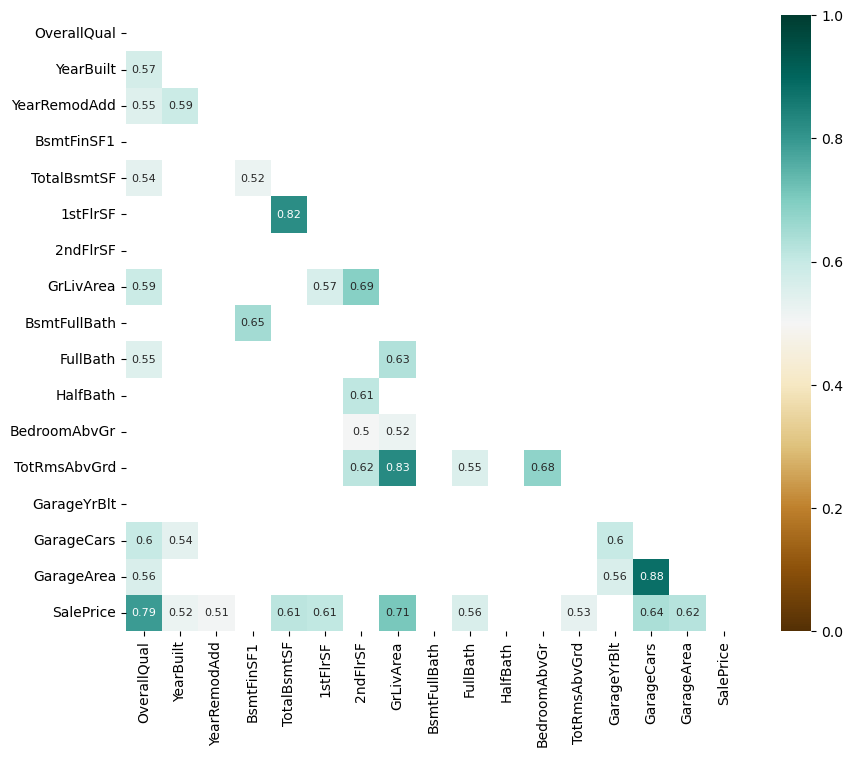

In [144]:
# посмотрим матрицу корреляции (выведем коррляцию между показаетлями > 0.5)
corr = df.corr()
col_to_remove = [col for col in corr.columns if len([1 for i in corr[col].abs() if i <= 0.5]) == len(corr[col]) - 1]
corr = corr.drop(col_to_remove, axis=1, errors='ignore').drop(col_to_remove, axis=0, errors='ignore')

mask = np.triu(np.ones_like(corr, dtype= np.bool_))

plt.subplots(figsize=(10, 8))
sns.heatmap(corr[abs(corr)>0.5], 
            vmax=1.0, vmin=0.0,
            annot=True, annot_kws={"size": 8},
            cmap='BrBG', square=True,
            mask=mask)
plt.show()

# В датасете много коллинеарных признаков, для избавления от коллинерности воспользуемся SelectFromModel на этапах обучения модели и предсказания данных

### Исследование таргета

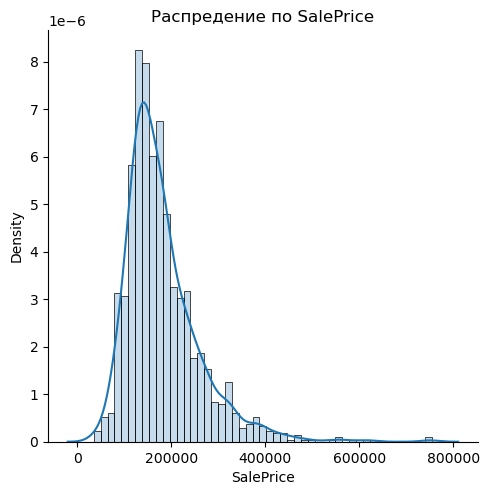

In [145]:
# рассмотрим распередение целевого признака
sns.displot(df["SalePrice"], kde = True, stat = "density", kde_kws = dict(cut=3), alpha=0.25)
plt.title(label="Распредение по SalePrice")
plt.show()

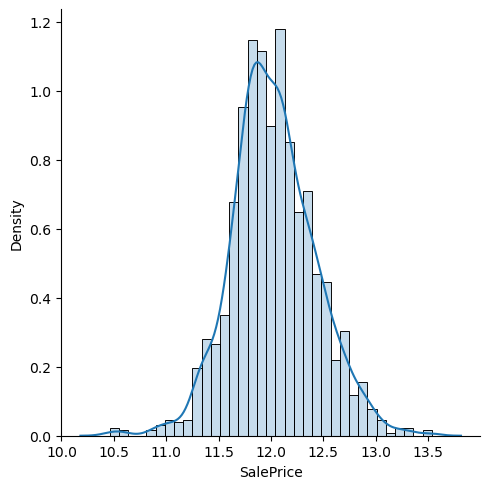

In [146]:
# рассмотрим распередение прологарифмированного целевого признака
log_sales = np.log1p(df["SalePrice"])
sns.displot(log_sales, kde = True, stat = "density", kde_kws = dict(cut=3), alpha=0.25)
plt.show()

#т.к. распределение прологарифмированного признака выглядит более нормальным - будем использовать его для обучения модели

## Обучение модели

### Выбор модели

In [147]:
X = df.values[0::, 0:-1]
y = np.log1p(df.values[0::, -1])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [148]:
alpha_values = [0.01, 0.1, 1, 10, 100]

selector = SelectFromModel(estimator=Lasso()).fit(X_train, y_train)
X_lasso = selector.transform(X_train)
scaler = StandardScaler().fit(X_lasso)
X_lasso = scaler.transform(X_lasso)

X_test_lasso = selector.transform(X_test)
X_test_lasso = scaler.transform(X_test_lasso)


for alpha in alpha_values:
    lreg = Lasso(alpha=alpha, max_iter=1000, tol=0.1)
    cross_val_scores = cross_val_score(lreg, X_lasso, y_train, cv=5, scoring='neg_mean_squared_error')
    print(f'alpha={alpha}')
    amse = (-cross_val_scores).mean()
    mse_list = [-i.round(4) for i in cross_val_scores]
    print(f'AVG MSE:{amse:.4f}\n{mse_list}\n')


alpha=0.01
AVG MSE:0.0437
[0.0462, 0.0828, 0.031, 0.0243, 0.0344]

alpha=0.1
AVG MSE:0.0616
[0.0572, 0.0907, 0.0612, 0.0524, 0.0464]

alpha=1
AVG MSE:0.1516
[0.1378, 0.1912, 0.1576, 0.1418, 0.1295]

alpha=10
AVG MSE:0.1516
[0.1378, 0.1912, 0.1576, 0.1418, 0.1295]

alpha=100
AVG MSE:0.1516
[0.1378, 0.1912, 0.1576, 0.1418, 0.1295]



In [149]:
alpha_values = [0.01, 0.1, 1, 10, 100]

selector = SelectFromModel(estimator=Ridge()).fit(X_train, y_train)
X_ridge = selector.transform(X_train)
scaler = StandardScaler().fit(X_ridge)
X_ridge = scaler.transform(X_ridge)

X_test_ridge = selector.transform(X_test)
X_test_ridge = scaler.transform(X_test_ridge)

for alpha in alpha_values:
    lreg = Ridge(alpha=alpha, max_iter=2000, tol=0.01, solver='svd')
    cross_val_scores = cross_val_score(lreg, X_ridge, y_train, cv=5, scoring='neg_mean_squared_error')
    print(f'alpha={alpha}')
    amse = (-cross_val_scores).mean()
    mse_list = [-i.round(4) for i in cross_val_scores]
    print(f'AVG MSE:{amse:.4f}\n{mse_list}\n')


alpha=0.01
AVG MSE:0.0312
[0.0312, 0.0419, 0.0321, 0.0233, 0.0275]

alpha=0.1
AVG MSE:0.0312
[0.0312, 0.0419, 0.0321, 0.0233, 0.0275]

alpha=1
AVG MSE:0.0312
[0.0312, 0.0419, 0.0321, 0.0233, 0.0275]

alpha=10
AVG MSE:0.0312
[0.031, 0.0419, 0.032, 0.0234, 0.0275]

alpha=100
AVG MSE:0.0316
[0.0304, 0.0426, 0.0323, 0.0243, 0.0283]



In [150]:
C_values = [0.001, 0.01, 0.1, 1]
loss_values = ['epsilon_insensitive','squared_epsilon_insensitive']
selector = SelectFromModel(estimator=LinearSVR()).fit(X_train, y_train)
X_svr = selector.transform(X_train)
scaler = StandardScaler().fit(X_svr)
X_svr = scaler.transform(X_svr)

X_test_svr = selector.transform(X_test)
X_test_svr = scaler.transform(X_test_svr)

for loss in loss_values:
    print(f'Loss: {loss}')
    for C in C_values:
        LSVR = LinearSVR(C=C, tol=0.001, max_iter=1000, dual=True, loss=loss)
        cross_val_scores = cross_val_score(LSVR, X_svr, y_train, cv=5, scoring='neg_mean_squared_error')
        print(f'C={C}')
        amse = (-cross_val_scores).mean()
        mse_list = [-i.round(4) for i in cross_val_scores]
        print(f'AVG MSE:{amse:.4f}\n{mse_list}\n')

Loss: epsilon_insensitive
C=0.001
AVG MSE:128.5178
[129.3773, 128.0836, 127.6772, 128.7338, 128.717]

C=0.01
AVG MSE:26.2260
[27.6765, 25.3469, 26.0672, 25.9875, 26.0521]

C=0.1
AVG MSE:0.0476
[0.0429, 0.0604, 0.0498, 0.0431, 0.0419]

C=1
AVG MSE:0.0457
[0.042, 0.0605, 0.0468, 0.0395, 0.0398]

Loss: squared_epsilon_insensitive
C=0.001
AVG MSE:25.4511
[25.7508, 25.1057, 25.4532, 25.5987, 25.347]

C=0.01
AVG MSE:0.7028
[0.6956, 0.6887, 0.7127, 0.7307, 0.6865]

C=0.1
AVG MSE:0.0529
[0.0473, 0.0661, 0.0545, 0.0507, 0.046]

C=1
AVG MSE:0.0456
[0.0413, 0.061, 0.0464, 0.0399, 0.0396]



c:\Users\37529\.conda\envs\DS05\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\37529\.conda\envs\DS05\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\37529\.conda\envs\DS05\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### обучение моделей

In [154]:
model1 = Lasso(alpha=0.1, max_iter=1000, tol=0.1).fit(X_lasso, y_train)
model2 = Ridge(alpha=1, max_iter=2000, tol=0.01, solver='svd').fit(X_ridge, y_train)
model3 = LinearSVR(C=1, tol=0.001, max_iter=1000, dual=True, loss='epsilon_insensitive').fit(X_svr, y_train)
model4 = LinearSVR(C=1, tol=0.001, max_iter=1000, dual=True, loss='squared_epsilon_insensitive').fit(X_svr, y_train)

In [161]:
models_train = {1: [model1, X_lasso],
                2: [model2, X_ridge], 
                3: [model3, X_svr], 
                4: [model4, X_svr]}

In [169]:
models_test = {1: [model1, X_test_lasso], 
               2: [model2, X_test_ridge],
               3: [model3, X_test_svr],
               4: [model4, X_test_svr]}

In [166]:
def a(models):
    for i in models:
        if i == 1:
            y_pred = models[i][0].predict(models[i][1])
        else:
            y_pred += models[i][0].predict(models[i][1])
    y_pred = y_pred/4
    return y_pred

In [170]:
y_pred_train = a(models_train)
y_pred_test = a(models_test)

In [171]:
MAPE = metrics.mean_absolute_percentage_error(np.expm1(y_train), np.expm1(y_pred_train))
print(f'MAPE for train data: {MAPE}')

MAPE = metrics.mean_absolute_percentage_error(np.expm1(y_test), np.expm1(y_pred_test))
print(f'MAPE for test data: {MAPE}')

MAPE for train data: 0.1356830354081388
MAPE for test data: 0.140762994330211
